In [1]:
from my_functions import *

In [2]:
%load_ext autoreload
%autoreload 2

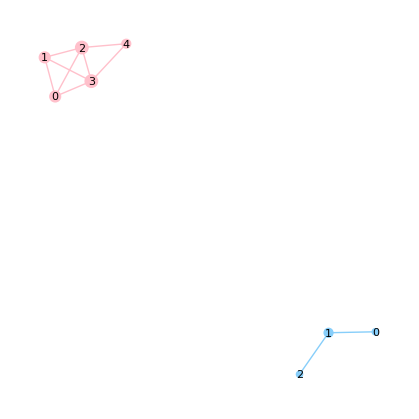

HeteroData(
  rmsd=0.0,
  protein={
    atoms=[5],
    pos=[5, 3]
  },
  ligand={
    atoms=[3],
    pos=[3, 3]
  },
  (protein, -, protein)={
    edge_index=[2, 8],
    edge_attr=[2]
  },
  (ligand, -, ligand)={
    edge_index=[2, 2],
    edge_attr=[2]
  },
  (protein, -, ligand)={
    edge_index=[2, 0],
    edge_attr=[2]
  }
)

In [3]:
data = generate_complex(5, 3, 3, threshold=1.8, mu_std=2.5)
show_complex_networx(data, 'pos')
data

In [4]:
dataset = ProteinLigandComplexes()

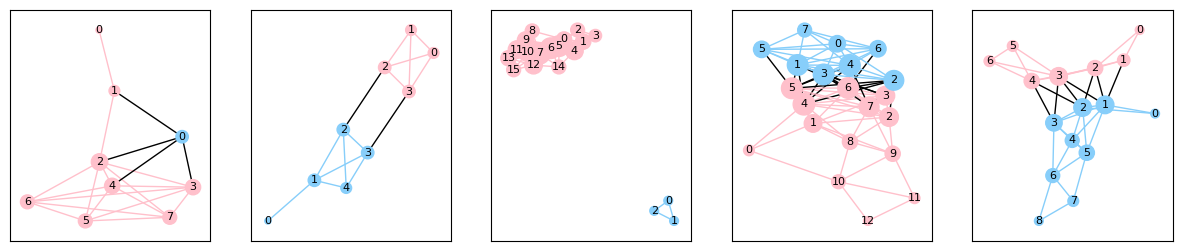

In [5]:
show_complex_batch_networx([dataset[i] for i in range(5)], 'pos')

In [6]:
# from transformer_m import TransformerM


A molecule $\mathcal{M}$ is made up of a collection of atoms held together by attractive forces. We denote $X \in \mathbb{R}^{n \times d}$ as the atoms with features, where $n$ is the number of atoms, and $d$ is the feature dimension. The structure of $\mathcal{M}$ can be represented in different formulations, such as 2D graph structure and 3D geometric structure. For the 2D graph structure, atoms are explicitly connected by chemical bonds, and we define $\mathcal{M}^{2D} = (X, E)$, where $e(i,j) \in E$ denotes the edge feature (i.e., the type of the bond) between atom $i$ and $j$ if the edge exists. For the 3D geometric structure, for each atom $i$, its position $r_i$ in the Cartesian coordinate system is provided. We define $\mathcal{M}^{3D} = (X, R)$, where $R = \{r_1 , ..., r_n \}$ and $r_i ∈ \mathbb{R}^3$. Our goal is to design a parametric model which can take either $\mathcal{M}^{2D}$ or $\mathcal{M}^{3D}$ (or both of them) as input, obtain contextual representations, and make predictions on downstream tasks.

**Encoding pair-wise relations in $E$.**
We use two terms to encode the structural relations between any atom pairs in the graph. First, we encode the shortest path distance (SPD) between two atoms to reflect their spatial relation. Let $\Phi_{ij}^{SPD}$ denote the SPD encoding between atom $i$ and $j$, which is a learnable scalar determined by the distance of the shortest path between $i$ and $j$. Second, we encode the edge features (e.g., the chemical bond types) along the shortest path between $i$ and $j$ to reflect the bond information. For most molecules, there exists only one distinct shortest path between any two atoms. Denote the edges in the shortest path from $i$ to $j$ as $SP_{ij} = (e_1, e_2, ..., e_N)$, and the edge encoding between $i$ and $j$ is defined as $$\Phi_{ij}^{Edge} = \frac{1}{N} \sum_{n=1}^N e_n(w_n)^T,$$ where $w_n$ are learnable vectors of the same dimension as the edge feature. Denote $\Phi^{SPD}$ and $\Phi^{Edge}$ as the matrix form of the SPD encoding and edge encoding, both of which are of shape $n \times n$.

In [6]:
data = generate_complex(6, 3, 3, threshold=1.8, mu_std=2.5)

In [53]:
data['protein']

{'atoms': tensor([5, 3, 3, 8, 5, 1]), 'pos': tensor([[-0.0014, -0.7429, -0.6029],
        [-0.1212, -0.8719, -0.2890],
        [-0.4986,  0.0473, -0.4389],
        [-0.2025, -0.3034,  0.5337],
        [ 0.6825,  0.6170,  0.0990],
        [ 0.1413,  1.2540,  0.6981]])}

In [29]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall

n = len(data['protein'].atoms)
atoms_from, atoms_to = data['protein', '-', 'protein'].edge_index
row = atoms_from.numpy() 
col = atoms_to.numpy() 
is_bond = torch.ones_like(atoms_from).numpy()
graph = csr_matrix((is_bond, (row, col)), shape=(n, n))
dist_matrix, path = floyd_warshall(csgraph=graph, directed=False, return_predecessors=True)
spatial_pos = torch.from_numpy((dist_matrix)).long()

print(graph.toarray())
print(spatial_pos)
print(path)

[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 0 0 0 0]
 [1 1 1 0 0 0]
 [1 0 1 1 0 0]
 [0 0 1 1 1 0]]
tensor([[0, 1, 1, 1, 1, 2],
        [1, 0, 1, 1, 2, 2],
        [1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1],
        [1, 2, 1, 1, 0, 1],
        [2, 2, 1, 1, 1, 0]])
[[-9999     0     0     0     0     2]
 [    1 -9999     1     1     0     2]
 [    2     2 -9999     2     2     2]
 [    3     3     3 -9999     3     3]
 [    4     0     4     4 -9999     4]
 [    2     2     5     5     5 -9999]]


In [30]:
max_dist = np.amax(dist_matrix).astype(np.int64)
max_dist

2

In [9]:
atom_types_number = 10
bond_types_number = atom_types_number ** 2 + 1
bond_types = integer_symmetric_matrix(bond_types_number, atom_types_number, atom_types_number)
bond_types

tensor([[18, 62, 75, 78, 93, 72, 36, 56, 14, 39],
        [62, 18, 61,  4, 55, 35, 21,  3, 16, 39],
        [75, 61, 56, 67, 10,  8, 88, 30, 78,  4],
        [78,  4, 67, 91, 30,  8,  1,  3, 87, 53],
        [93, 55, 10, 30, 87, 39, 91, 69, 20, 58],
        [72, 35,  8,  8, 39,  2, 63, 56, 84, 65],
        [36, 21, 88,  1, 91, 63, 11, 62,  1, 53],
        [56,  3, 30,  3, 69, 56, 62, 41, 31,  9],
        [14, 16, 78, 87, 20, 84,  1, 31, 43,  7],
        [39, 39,  4, 53, 58, 65, 53,  9,  7, 34]])

In [56]:
def shortest_path_sequence(path, atoms_number, max_dist, atoms_types):
    bonds = np.zeros((atoms_number, atoms_number, max_dist), dtype=np.int64)
    atoms_to = np.broadcast_to(np.arange(atoms_number), (atoms_number, atoms_number))
    atoms_from = atoms_to.T
    atoms_inner = np.ones((atoms_number, atoms_number), dtype=np.int64)
    mask = path != -9999
    for k in range(1, max_dist+1):
        atoms_inner[mask] = path[atoms_from[mask], atoms_to[mask]]
        bonds[:, :, k-1][mask] = bond_types[
            atoms_types[atoms_to[mask]], 
            atoms_types[atoms_inner[mask]]
        ]
        mask *= atoms_inner != atoms_from
        atoms_to = atoms_inner.copy()
        atoms_inner[...] = 0
    return bonds

In [57]:
shortest_path_sequence(path, n, max_dist, data['protein'].atoms).T

array([[[ 0,  8,  8, 84,  2,  8],
        [ 8,  0, 91, 87,  8, 91],
        [ 8, 91,  0, 87,  8,  4],
        [84, 87, 87,  0, 84, 16],
        [ 2,  2,  8, 84,  0, 35],
        [ 4,  4,  4, 16, 35,  0]],

       [[ 0,  0,  0,  0,  0,  4],
        [ 0,  0,  0,  0,  2,  4],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  8,  0,  0,  0,  0],
        [ 8, 91,  0,  0,  0,  0]]])

In [ ]:
def preprocess_item(data):
    edge_attr, edge_index, x = data.edge_attr, data.edge_index.to(torch.int64), data.x
    N = x.size(0)
    x = convert_to_single_emb(x)

    # node adj matrix [N, N] bool
    adj = torch.zeros([N, N], dtype=torch.bool)
    adj[edge_index[0, :], edge_index[1, :]] = True

    # edge feature here
    if len(edge_attr.size()) == 1:
        edge_attr = edge_attr[:, None]
    attn_edge_type = torch.zeros([N, N, edge_attr.size(-1)], dtype=torch.long)
    attn_edge_type[edge_index[0, :], edge_index[1, :]
                   ] = convert_to_single_emb(edge_attr) + 1
    shortest_path_result, path = algos.floyd_warshall(adj.numpy())

    max_dist = np.amax(shortest_path_result)
    edge_input = algos.gen_edge_input(max_dist, path, attn_edge_type.numpy())

    spatial_pos = torch.from_numpy((shortest_path_result)).long()
    attn_bias = torch.zeros(
        [N + 1, N + 1], dtype=torch.float)  # with graph token

    # combine
    item.x = x
    item.attn_bias = attn_bias
    item.attn_edge_type = attn_edge_type
    item.spatial_pos = spatial_pos
    item.in_degree = adj.long().sum(dim=1).view(-1)
    item.out_degree = item.in_degree # for undirected graph
    item.edge_input = torch.from_numpy(edge_input).long()

    return item

In [7]:
import torch.nn as nn

In [ ]:
class AtomFeature(nn.Module):
    """
    Compute atom features for each atom in the molecule.
    """
    def __init__(self, num_heads, num_atoms, num_in_degree, num_out_degree, hidden_dim):
        super().__init__()
        self.num_heads = num_heads
        self.num_atoms = num_atoms
        self.atom_encoder = nn.Embedding(num_atoms + 1, hidden_dim, padding_idx=0)
        self.in_degree_encoder = nn.Embedding(num_in_degree, hidden_dim, padding_idx=0)
        self.out_degree_encoder = nn.Embedding(num_out_degree, hidden_dim, padding_idx=0)
        self.graph_token = nn.Embedding(1, hidden_dim)
        # self.apply(lambda module: init_params(module, n_layers=n_layers))

    def forward(self, batched_data):
        x, in_degree, out_degree = batched_data['x'], batched_data['in_degree'], batched_data['out_degree']
        n_graph, n_node = x.size()[:2]
        # node feauture + graph token
        node_feature = self.atom_encoder(x).sum(dim=-2) # [n_graph, n_node, n_hidden]
        degree_feature = self.in_degree_encoder(in_degree) + self.out_degree_encoder(out_degree)
        node_feature = node_feature + degree_feature
        graph_token_feature = self.graph_token.weight.unsqueeze(0).repeat(n_graph, 1, 1)
        graph_node_feature = torch.cat([graph_token_feature, node_feature], dim=1)
        return graph_node_feature

In [ ]:
class Encoding2D(nn.Module):
    """
    Compute Phi
    """
    def __init__(self, num_heads, num_atoms, num_edges, num_spatial, num_edge_dis, 
                 hidden_dim, edge_type, multi_hop_max_dist, n_layers):
        super().__init__()
        self.num_heads = num_heads
        self.multi_hop_max_dist = multi_hop_max_dist

        self.edge_encoder = nn.Embedding(num_edges + 1, num_heads, padding_idx=0)

        self.edge_dis_encoder = nn.Embedding(num_edge_dis * num_heads * num_heads, 1)
        self.spatial_pos_encoder = nn.Embedding(num_spatial, num_heads, padding_idx=0)

        self.graph_token_virtual_distance = nn.Embedding(1, num_heads)
        # self.apply(lambda module: init_params(module, n_layers=n_layers))

    def forward(self, batched_data, mask_2d=None):
        attn_bias, spatial_pos, x = batched_data['attn_bias'], batched_data['spatial_pos'], batched_data['x']
        edge_input, attn_edge_type = batched_data['edge_input'], batched_data['attn_edge_type']

        n_graph, n_node = x.size()[:2]
        graph_attn_bias = attn_bias.clone()
        # [n_graph, n_head, n_node+1, n_node+1]
        graph_attn_bias = graph_attn_bias.unsqueeze(1).repeat(1, self.num_heads, 1, 1)

        # --------------------------------------------------------------------
        # эмбедим spd
        # spatial pos
        # [batch_size, n, n]
        spatial_pos = batched_data['spatial_pos']
        # [batch_size, n, n, n_head] -> [batch_size, n_head, n, n]
        spatial_pos_bias = self.spatial_pos_encoder(spatial_pos).permute(0, 3, 1, 2)
        graph_attn_bias[:, :, 1:, 1:] = graph_attn_bias[:, :, 1:, 1:] + spatial_pos_bias
        # --------------------------------------------------------------------

        # reset spatial pos here
        t = self.graph_token_virtual_distance.weight.view(1, self.num_heads, 1)
        graph_attn_bias[:, :, 1:, 0] = graph_attn_bias[:, :, 1:, 0] + t
        graph_attn_bias[:, :, 0, :] = graph_attn_bias[:, :, 0, :] + t

        # --------------------------------------------------------------------
        # [batch_size, n, n, dist, ?]
        edge_input = batched_data['edge_input']
        edge_input = edge_input[:, :, :, :self.multi_hop_max_dist, :] # [batch_size, n, n, max_dist, ?]
        # [batch_size, n, n, max_dist, ?, n_head] -> [batch_size, n, n, max_dist, n_head]
        edge_input = self.edge_encoder(edge_input).mean(-2) # [batch_size, n, n, max_dist, n_head]

        max_dist = edge_input.size(-2)
        # [batch_size, n, n, max_dist, n_head] -> [max_dist, batch_size, n, n, n_head] 
        #                                      -> [max_dist, batch_size x n x n, n_head]
        edge_input_flat = edge_input.permute(3, 0, 1, 2, 4).reshape(max_dist, -1, self.num_heads)
        edge_input_flat = torch.bmm(
            # [max_dist, batch_size x n x n, n_head]
            edge_input_flat, 
            # [num_edge_dis x n_head x n_head, 1] -> [num_edge_dis, n_head, n_head]
            #                                     -> [max_dist, n_head, n_head]
            self.edge_dis_encoder.weight.reshape(-1, self.num_heads, self.num_heads)[:max_dist, :, :]
        ) # [max_dist, batch_size x n x n, n_head]
        # [max_dist, batch_size x n x n, n_head] -> [max_dist, batch_size, n, n, n_head]
        #                                        -> [batch_size, n, n, max_dist, n_head]
        edge_input = edge_input_flat.reshape(max_dist, n_graph, n_node, n_node, self.num_heads).permute(1, 2, 3, 0, 4)

        # это должно быть количеством ребер в кратчайшем пути - N
        spatial_pos = batched_data['spatial_pos']
        spatial_pos_ = spatial_pos.clone()
        spatial_pos_[spatial_pos_ == 0] = 1  # set pad to 1
        # set 1 to 1, x > 1 to x - 1
        spatial_pos_ = torch.where(spatial_pos_ > 1, spatial_pos_ - 1, spatial_pos_)
        spatial_pos_ = spatial_pos_.clamp(0, self.multi_hop_max_dist)

        # [batch_size, n, n, n_head] / [batch_size, n, n, n_head] -> [batch_size, n_head, n, n]
        edge_input = (edge_input.sum(-2) / (spatial_pos_.float().unsqueeze(-1))).permute(0, 3, 1, 2)
        # 
        graph_attn_bias[:, :, 1:, 1:] = graph_attn_bias[:, :, 1:, 1:] + edge_input
        # --------------------------------------------------------------------

        graph_attn_bias = graph_attn_bias + attn_bias.unsqueeze(1)  # reset
        return graph_attn_bias

**Encoding pair-wise relations in $R$**. 
We encode the Euclidean distance to reflect the spatial relation between any pair of atoms in the 3D space. For each atom pair $(i,j)$, we first process their Euclidean distance with the Gaussian Basis Kernel function, 
$$
\psi^k_{(i, j)} =
-\frac{1}{\sqrt{2 \pi |\sigma^k|}}
\exp{-\frac{1}{2} \left( 
    \frac{\gamma_{(i, j)} \|r_i - r_j\| + \beta_{(i, j)} - \mu^k}
    {|\sigma^k|} 
\right)^2},
$$
$k = 1, ..., K$, where $K$ is the number of Gaussian Basis kernels. Then the 3D Distance encoding $\Phi_{ij}^{3D}$ Distance is obtained according to 
$$
\Phi_{ij}^{3D} = 
\text{GELU}(\psi_{(i,j)} W_D^1) W_D^2,
$$
where $\psi_{(i,j)} = [\psi_{(i,j)}^1, ..., \psi_{(i,j)}^K]^T, W_D^1 \in \mathbb{R}^{K \times K}, W_D^2 \in \mathbb{R}^{K \times 1}$ are learnable parameters. $\gamma_{(i,j)}, \beta_{(i,j)}$ are learnable scalars indexed by the pair of atom types, and $\mu^k, \sigma^k$ are learnable kernel center and learnable scaling factor of the $k$-th Gaussian Basis Kernel. Denote $\Phi_{ij}^{3D}$ Distance as the matrix form of the 3D distance encoding, whose shape is $n \times n$.

In [38]:
atom_types_number = 10
bond_types_number = atom_types_number ** 2 + 1

In [32]:
# Check Gaussian Layer for a random tensor
n = 3
K = 5
gf = GaussianLayer(K)
x = torch.rand(n, n)
edge_types = torch.tensor(np.random.choice(bond_types_number, size=n*n)).reshape(n, n).long()
print('Edge types:')
print(edge_types)
assert gf(x, edge_types).shape == torch.Size([n, n, K])

Edge types:
tensor([[32, 89, 19],
        [90, 85, 41],
        [77,  3, 81]])


In [34]:
# Check Gaussian Layer for a given data
n = data['protein'].pos.shape[0]
K = 5
gf = GaussianLayer(K)
x = torch.cdist(data['protein'].pos, data['protein'].pos)
edge_types = torch.zeros_like(x).long()
atoms_from, atoms_to = data['protein', '-', 'protein'].edge_index
edge_types[atoms_from, atoms_to] = edge_types[atoms_to, atoms_from] = data['protein', '-', 'protein'].edge_attr[1]
assert gf(x, edge_types).shape == torch.Size([n, n, K])

In [37]:
# Check Encoding3D Layer for a given data
n_heads = 1
encoder3d = Encoding3D(n_heads=n_heads)
pos = data['protein'].pos
edge_types = torch.zeros_like(x).long()
atoms_from, atoms_to = data['protein', '-', 'protein'].edge_index
edge_types[atoms_from, atoms_to] = edge_types[atoms_to, atoms_from] = data['protein', '-', 'protein'].edge_attr[1]

assert encoder3d(pos, edge_types).shape == torch.Size([n, n, n_heads])